# Predicting gaussians

the connection between A|B and B|A is:

$$A \sim \mathcal{N}(\mu_A, \sigma_A^2)$$
$$B|A \sim \mathcal{N}(\alpha A + \beta, \sigma^2) $$
then
$$ \mu_B = \alpha \mu_A + \beta $$
$$ \sigma_B^2 = \sigma^2 + (\alpha \sigma_A)^2 $$
and 
$$ A|B \sim \mathcal{N}(\tilde \alpha B + \tilde \beta, \tilde \sigma^2)$$
where
$$\tilde \alpha =  \frac{\sigma_A^2}{\sigma_B^2} \alpha \quad \text{and} \quad \tilde \sigma^2 = \frac{\sigma_A^2}{\sigma_B^2} \sigma^2$$
$$\tilde \beta = \frac{\sigma^2}{\sigma_B^2} \mu_A - \tilde \alpha \beta$$


* TODO: study the $5\times 5$ jacobian via pytorch.
* TODO: what is the convergence speed of each model under the true gradient update? which one is faster depending on the step-size etc...? Note that this does not rely on the statistical bounds mentionned by Yoshua.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
%matplotlib inline

In [10]:
class Conjugate(nn.Module):
    
    def __init__(self):
        super(Conjugate, self).__init__()
        
    def forward(self, conditional_tensor):
        mua, vara, alpha, beta, varcond = tuple(conditional_tensor)
        
        mub = alpha*mua + beta
        varb = varcond + alpha**2 * vara
        
        # reverse conditional
        ralpha = alpha * vara/varb
        rbeta = mua* varcond /varb - ralpha * beta
        rvarcond = varcond * vara/varb
        
        return torch.stack([mub, varb, ralpha, rbeta, rvarcond])


In [11]:
class Conditional():
    
    def __init__(self, mua, vara, alpha, beta, varcond, atob=True):
        self.mua = mua
        self.vara = vara
        self.alpha = alpha
        self.beta = beta
        self.varcond = varcond
        self.atob = atob
        
    def to_list(self):
        return [self.mua, self.vara, self.alpha, self.beta, self.varcond]
    
    def to_tensor(self):
        return torch.tensor(self.to_list())
    
    def joint_parameters(self):
        mean = np.array([self.mua, self.alpha*self.mua+self.beta])
        covariance = np.array([[self.vara, self.alpha*self.vara],
                              [self.alpha*self.vara, self.varcond + self.alpha**2 * self.vara]])
        return mean, covariance
        
    def sample(self,n):
        a = self.mua + np.sqrt(self.vara) * np.random.randn(n)
        b = self.alpha * a + self.beta + np.sqrt(self.varcond) * np.random.randn(n)
        if self.atob:
            return a, b
        else:
            return b, a
    
    def density(self, a, b):
        pa = np.exp(- (a - self.mua)**2 / 2 /self.vara) / np.sqrt(2*np.pi*self.vara)
        pba = np.exp(- (b - self.alpha * a - self.beta)**2 / 2 / self.varcond) / np.sqrt(2 * np.pi * self.varcond)
        return pa * pba
    
    def plot(self, color='red'):
        """Draw the conditional line"""
        # line
        window = 5*np.sqrt(self.vara)
        a = np.linspace(self.mua - window, self.mua + window, 100)
        b = self.alpha*a + self.beta
        if self.atob:
            plt.plot(a, b, color=color)
        else:
            plt.plot(b,a, color=color)
        
        # contour
        aa, bb = np.meshgrid(a, b, indexing='ij')
        pp = self.density(aa, bb)
        if self.atob:
            plt.contour(aa, bb, pp)
        else:
            plt.contour(bb,aa, pp)

a : [ 5.91466646  0.74240966  2.78676296]
b : [ 1.37171845  1.66100803  2.63260012]
density : [ 0.01138018  0.03883962  0.05159111]


(-8.180339887498949,
 14.180339887498949,
 -4.1207972930266417,
 7.9207974837615049)

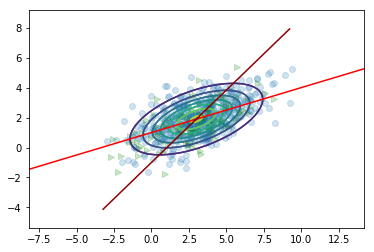

In [12]:
# a to b
model = Conditional(3, 5, .3, 1, 1)
a,b = model.sample(3)
print('a :', a)
print('b :', b)
print('density :', model.density(a,b))

plt.scatter(*model.sample(500), alpha=.2)
model.plot()

# b to a\
conj = Conjugate()
rmodel = Conditional(*conj(model.to_tensor()).tolist(), atob=False)
plt.scatter(*rmodel.sample(100), alpha=.2, marker='>',color='green')
rmodel.plot(color='darkred')
plt.axis('equal')

# the model are matching, the formulas must be correct

# Single direction update effect on the conjugate

In [174]:
def single_variation(base_parameters, parid, parvalues):
    """Take a base point (as a tensor), a parameter number and a range to try with this variable. 
    Plot the evolution of conjugate parameters on this range.
    """
    parameters = base_parameters.unsqueeze(1).repeat(1, parvalues.shape[0])
    parameters[parid] = parvalues
    
    conjugator = Conjugate()
    conjugated = conjugator(parameters)
    
    return conjugated
    

In [1]:
base = torch.tensor([3, 4, .3, 1, 1])

resolution =100
experimental_values = [
    torch.linspace(-3,3,resolution), # mua
    torch.linspace(0.1, 2, resolution)**2,  # vara
    torch.linspace(0,2, resolution), # alpha
    torch.linspace(-2,2, resolution),  # beta
    torch.linspace(0.1, 2, resolution)**2,  # varcond
]

parameter_names = ['mua', 'vara', 'alpha', 'beta', 'varcond']

for parid in range(5):
    # compute 
    testvalues = experimental_values[parid]
    conjugates = single_variation(base, parid, testvalues).numpy()
    distance = np.sqrt(np.sum((conjugates.T - conjugates[:,0])**2, axis=1))
                          
    # plot
    xrange = testvalues.numpy()
    plt.figure(figsize=(10, 4))
    plt.title(f"Move {parameter_names[parid]}"
              f" from base {base.numpy()}.")
    
    plt.plot(xrange, xrange - xrange[0], linewidth=4, linestyle='--', label=r'causal $\ell^2$')
    plt.plot(xrange, distance, linewidth=4, linestyle='--', label=r'conjugate $\ell^2$')
    
    for i, name in enumerate(parameter_names):
        plt.plot(xrange, conjugates[i], label=name)
            
    plt.legend()
    plt.show()

NameError: name 'torch' is not defined

# Natural parameters of a multivariate gaussian
Reference : https://www.cs.princeton.edu/~bee/courses/scribe/lec_09_09_2013.pdf

The formula relating both parametrization is $\eta = \Sigma^{-1} \mu$ and $\Lambda = \Sigma^{-1}$. Note that this is symmetric meaning that we can use the natural parameters as the mean parameters of another gaussian. How are these two gaussians related ? Let's visualize it.

In [39]:
class MultivariateGaussian():
    
    def __init__(self, mean, covariance):
        """Gaussian distribution. 
        Note that we use the natural parameters instead of the mean parameters 
        because this is what appears in the density formula.
        """
        if not is_pos_def(covariance):
            raise ValueError("covariance argument should be a positive definite matrix")
        
        self.dim = mean.shape[0]
        self.mean = mean
        self.covariance = covariance
        
        self.precision = np.linalg.inv(covariance)
        self.eta =  np.dot(self.precision, mean)
        
        self.logpartition = .5* ( 
            np.dot(self.eta, np.dot(self.precision, self.eta))
            + np.log(np.linalg.det(self.precision))
            + self.dim * np.log(2*np.pi)
        )
        
    def __repr__(self):
        return f"Normal with mean {self.mean} and covariance \n {self.covariance}"
        
    def logdensity(self, x):
        # 1st dimension of x should be self.dim
        return np.dot(self.eta, x) + np.dot(np.dot(self.precision, x), x) - self.logpartition
        
    def sample(self,n):
        return np.random.multivariate_normal(self.mean, self.covariance, size=n)
        
        
def is_pos_def(A):
    if np.array_equal(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False
    
def contour(density_func, bottom, top, left, right, resolution=100):
    a = np.linspace()    
    aa, bb = np.meshgrid(a, b, indexing='ij')
    pp = density_func(aa, bb)
    plt.contour(aa, bb, pp)


In [40]:
model = Conditional(3, 5, .3, 1, 1)
mvg = MultivariateGaussian(*model.joint_parameters())
dual_mvg = MultivariateGaussian(mvg.eta, mvg.precision)

In [41]:
print(mvg)
print(dual_mvg)

Normal with mean [ 3.   1.9] and covariance 
 [[ 5.    1.5 ]
 [ 1.5   1.45]]
Normal with mean [ 0.3  1. ] and covariance 
 [[ 0.29 -0.3 ]
 [-0.3   1.  ]]


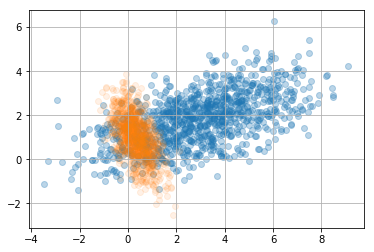

In [47]:
mvg_samples = mvg.sample(1000)
dual_samples = dual_mvg.sample(1000)
plt.scatter(mvg_samples[:,0],mvg_samples[:,1], alpha=.3)
plt.scatter(dual_samples[:,0],dual_samples[:,1], alpha=.1)
plt.grid()

There does not seem to be any super interesting pattern emerging from there.